In [6]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import tensorflow as tf

In [7]:


open_eyes_path = "training_data/Open_Eyes"
closed_eyes_path = "training_data/Closed_Eyes"

IMG_SIZE = 48  
CHANNELS = 1   


def load_images(folder_path, label):
    images = []
    labels = []
    for file in os.listdir(folder_path):
        if file.endswith('.png'):
            try:
                image_path = os.path.join(folder_path, file)
                image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)           
            
                if image is None:
                    print(f"Warning: Could not read image {file}")
                    continue
                    
              
                image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
                images.append(image)
                labels.append(label)
            except Exception as e:
                print(f"Error processing {file}: {str(e)}")
    return images, labels


open_eyes, open_labels = load_images(open_eyes_path, 1)
closed_eyes, closed_labels = load_images(closed_eyes_path, 0)


X = np.array(open_eyes + closed_eyes)
y = np.array(open_labels + closed_labels)

print(f"Class distribution: {np.bincount(y)}")
print(f"Open eyes: {len(open_eyes)} | Closed eyes: {len(closed_eyes)}")

X = X.reshape(-1, IMG_SIZE, IMG_SIZE, CHANNELS) / 255.0
y = to_categorical(y, num_classes=2)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    stratify=y,
    shuffle=True
)



print(f"Dataset loaded: {len(X)} samples (Training: {len(X_train)}, Test: {len(X_test)})")

Class distribution: [2000 2000]
Open eyes: 2000 | Closed eyes: 2000
Dataset loaded: 4000 samples (Training: 3200, Test: 800)


In [8]:

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, CHANNELS)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    
    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    

    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(2, activation='softmax')
])


reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2,
    patience=3,
    min_lr=1e-6
)


model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy', 
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')]
)

model.summary()

c:\Users\User\Desktop\BSCS\6th Semester\Computer Vision\CV project final\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 46, 46, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 21, 21, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 651,266 (2.48 MB)

 Trainable params: 650,818 (2.48 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 26s 55ms/step - accuracy: 0.8798 - loss: 0.8892 - precision: 0.8798 - recall: 0.8798 - val_accuracy: 0.7600 - val_loss: 0.9550 - val_precision: 0.7600 - val_recall: 0.7600
Epoch 2/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 24s 60ms/step - accuracy: 0.9878 - loss: 0.6130 - precision: 0.9878 - recall: 0.9878 - val_accuracy: 0.9975 - val_loss: 0.5696 - val_precision: 0.9975 - val_recall: 0.9975
Epoch 3/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 24s 60ms/step - accuracy: 0.9927 - loss: 0.5781 - precision: 0.9927 - recall: 0.9927 - val_accuracy: 0.9975 - val_loss: 0.5555 - val_precision: 0.9975 - val_recall: 0.9975
Epoch 4/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 23s 56ms/step - accuracy: 0.9970 - loss: 0.5426 - precision: 0.9970 - recall: 0.9970 - val_accuracy: 0.9975 - val_loss: 0.5343 - val_precision: 0.9975 - val_recall: 0.9975
Epoch 5/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.9930 - loss: 0.5370 - precision: 0.9930 - recall: 0.9930 - val_accuracy: 0.9975 - va

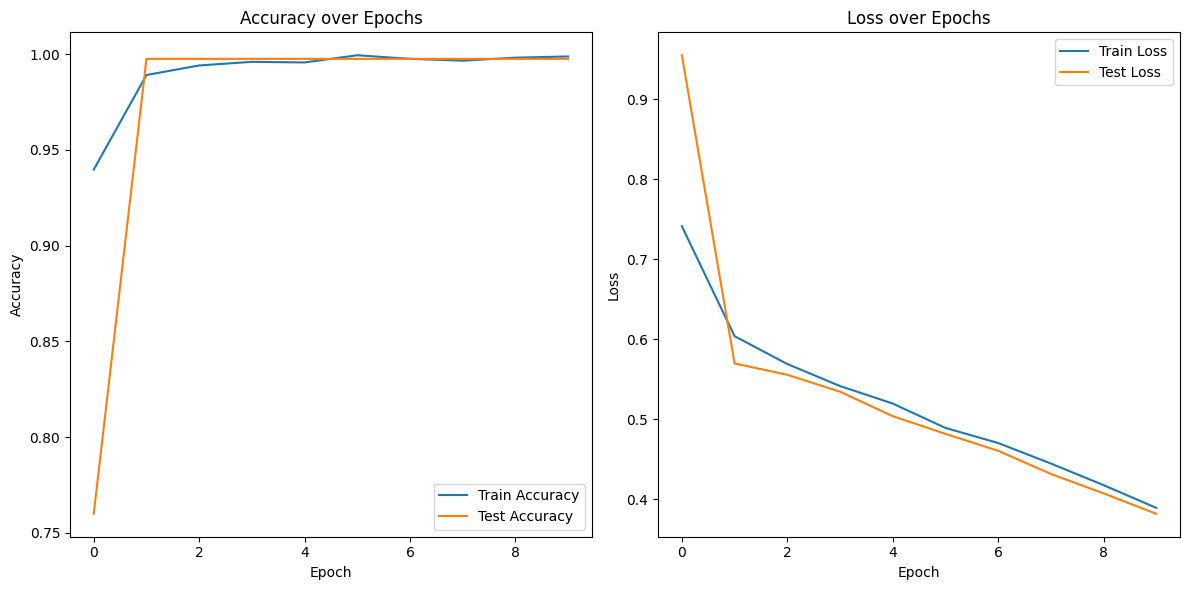

In [ ]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [10]:
model.save('drowsiness_model.h5')